# ?


As a self-recognized music-enthusiast, I listen to music almost every day, while working, running, or just to relax. I used to use NetEase Cloud for streaming music when I was in China, while after I start my Master's program in the United States, I switched to Spotify. Both NetEase and Spotify provide yearly wrap-up service to let users look back on their favorite songs of the year. Beyond that, I really aspired to know other characteristics of the songs or artists that I loved. Therefore, I have collected track information and features from both streaming history and my self-created playlists to build my own music streaming story.  

I will break down the article to two parts: The first part takes you through how I connect to Spotify APIs and retrieve the music data that I need. The second part displays the exploratory analysis of the streaming history and playlist tracks. Let's put the beats on!

# Part I: Get the data through Spotify APIs

To scrap data via python, let's use the python package "spotipy" for spotify in the following url:  
https://spotipy.readthedocs.io/en/2.9.0/#getting-started

Beyond that, I have referred the following blogs or document to scrap data from Spotify:

https://github.com/juandes/spotify-audio-features-data-experiment/blob/master/get_data.py

https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/

https://towardsdatascience.com/get-your-spotify-streaming-history-with-python-d5a208bbcbd3

In [52]:
# install the package
# !pip install spotipy

In [41]:
from __future__ import print_function    # (at top of module)
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import sys 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
from collections import OrderedDict
from math import log
import calmap

In [4]:
import plotly
from plotly import __version__
print (__version__)
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot

4.6.0


In [5]:
#plotly setup
init_notebook_mode(connected=True)

In [6]:
pd.set_option('display.max_colwidth', -1)

## I.1 Download the streaming history

Refer to my blog.

## I.2 Retrieve track features of your streaming history from Spotify APIs

In [1]:
import json
from pprint import pprint

In [5]:
with open('StreamingHistory0.json', encoding='utf8') as f:
    data = json.load(f)

pprint(data[:5])

[{'artistName': 'DyoN Joo',
  'endTime': '2019-07-13 02:41',
  'msPlayed': 0,
  'trackName': '#Life_Is_Pain'},
 {'artistName': 'DyoN Joo',
  'endTime': '2019-07-13 02:43',
  'msPlayed': 69662,
  'trackName': '#Life_Is_Pain'},
 {'artistName': 'MoonMoon',
  'endTime': '2019-07-13 02:46',
  'msPlayed': 0,
  'trackName': 'Eden'},
 {'artistName': 'H a lot',
  'endTime': '2019-07-13 02:46',
  'msPlayed': 80640,
  'trackName': 'If You Ask Me'},
 {'artistName': 'MoonMoon',
  'endTime': '2019-07-13 02:47',
  'msPlayed': 34219,
  'trackName': 'Eden'}]


In [6]:
# Convert from JSON to a data frame

spotify_data = pd.DataFrame()

def extract_json_value(column_name):
    
    return [i[column_name] for i in data]

spotify_data['artist_name'] = extract_json_value('artistName')
spotify_data['end_time'] = extract_json_value('endTime')
spotify_data['ms_played'] = extract_json_value('msPlayed')
spotify_data['track_name'] = extract_json_value('trackName')


In [7]:
spotify_data.sample(10)

,artist_name,end_time,ms_played,track_name
2516,Shannon,2020-03-17 05:34,196928,왜요 왜요
5330,John White,2020-06-10 18:31,231683,Piano Sonata No. 104
5123,Domenico Scarlatti,2020-06-07 07:31,299000,"Sonata In E, Kk.380: Andante commodo"
4686,Fleetwood Mac,2020-05-26 07:39,257800,Dreams - 2004 Remaster
4575,Django Reinhardt,2020-05-24 19:31,173181,Honeysuckle Rose
2515,Shannon,2020-03-17 05:31,210594,Blue
4438,Izzeah,2020-05-19 18:18,217406,Coffee
4256,Rachael Yamagata,2020-05-09 05:09,218443,Black Sheep
3838,Johann Sebastian Bach,2020-04-25 17:56,163182,"Keyboard Partita No. 6 in E Minor, BWV 830: II..."
3107,The Macarons Project,2020-04-06 04:48,146184,Tonight You Belong to Me


### Get the features of streaming history

In [8]:
import spotipy.util as util

username = 'vincyhu' #input your username
client_id ='6dc054e3d1194241874db8c8e7fd446f' # input your client_id
client_secret = '9ea1801de3644f74a942f1afb0d5bff2'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)
# Now you can finally authorize your app. Once you click on Agree, 
# you will be taken to the Redirect URI, which may well be a nonexistent page. 
# Just copy the address and paste it in your Python console.

In [9]:
print(token)

BQBSbKVipKe__YIGv80sjaKUTa4gF1Tvu4SiUAy8lvcq1ISGdXPafTQs5-1s6HJHDGi_SUDMzO8fsGy69_QXBDz26k19p5cayUxSsYxR-ueQcA5xt2dzYDUzE8Uqnwzoe0wGG82Yf8Op6eTNyynWqP7ZMuvENKXrmGxi1pdyJh4B3D3-Jtu25Q


In [10]:
# obtain the track_IDs by using the API to search the name of our track, 
import requests

# write the function to get track_id
def get_id(track_name: str,artist:str, token: str) -> str:
    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }
    track_artist = track_name+ " " + artist
    params = [
    ('q',track_artist ),#q is the search query parameter
    ('type', 'track'),
    ]
    try:
        response = requests.get('https://api.spotify.com/v1/search', 
                    headers = headers, params = params, timeout = 10)
        json = response.json()
        first_result = json['tracks']['items'][0]
        track_id = first_result['id']
        return track_id
    except:
        return None

# Get track_id for streaming history    
spotify_data["track_id"] = spotify_data.apply(lambda x: get_id(x["track_name"],
                                                               x["artist_name"],
                                                                 token),axis=1)

In [12]:
spotify_data.sample(10)

,artist_name,end_time,ms_played,track_name,track_id
709,Miriam Yeung,2020-02-05 01:38,247617,煉金術,2XwXl0wO4LrHDa7RQC9vV0
2909,Franz Joseph Haydn,2020-03-26 21:24,375448,"String Quartet in C Major, Hob. III:77 ""Empero...",1B6xMyypT7BQfDm6xgDiMN
3844,Johann Sebastian Bach,2020-04-26 17:02,310948,"Italian Concerto in F Major, BWV 971: II. Andante",2RPeCwKap7tb9JlzLtRiJv
5061,Lara Liang,2020-06-05 22:47,213240,靠近一點點,01cO3ZfjGwlY7nMDDr5tDZ
287,Cho Hyungwoo,2019-08-27 04:13,135914,Wild Dream,None
3547,Scott Hamilton,2020-04-21 00:04,388181,The Shadow of Your Smile,5Bl1TC8Y1qh3ui6fGSWL5a
14,Various Artists,2019-07-13 03:05,129956,Theme 03,5iU0qwj4zBSevUMOgssrRw
940,JJ Lin,2020-02-12 04:21,11528,進階,0EQ7IBLaVhxF8qOA4E4sF8
4078,卓文萱,2020-05-02 04:50,101200,愛的主旋律,2uNHNnp1423TjUOUzP2c5W
2193,Yerin Baek,2020-03-12 23:19,247197,우주를 건너 Across the universe,37LGPxmWd0LLKt80PKEDfz


In [5]:
# filter the streaming data by non-null result
spotify_data_nonull = spotify_data["track_id"].dropna()
spotify_data_nonull

0       40oGhvKqLJmYFwPftCi78v
1       40oGhvKqLJmYFwPftCi78v
2       0o7DpobP2DG9TCCPlcnloZ
3       0jMjxod5Cu2IirSSBtTCVj
4       0o7DpobP2DG9TCCPlcnloZ
                 ...          
5475    6AxHm4YBmvrf63HCKmXvng
5476    6AxHm4YBmvrf63HCKmXvng
5477    6AxHm4YBmvrf63HCKmXvng
5478    0E2D6fO2qfr4qYrOROHQTY
5479    0E2D6fO2qfr4qYrOROHQTY
Name: track_id, Length: 5452, dtype: object

In [16]:
track = list(OrderedDict.fromkeys(spotify_data_nonull)) 
track

['40oGhvKqLJmYFwPftCi78v',
 '0o7DpobP2DG9TCCPlcnloZ',
 '0jMjxod5Cu2IirSSBtTCVj',
 '3YtEhe3PbaU1vEgFARYgO2',
 '3MdJSXjBarAYuuJ7rjJLDk',
 '2q1bGlCTSpYLcpm6uw6Erx',
 '5P8oNhL5XukRpwLSY97xJ3',
 '3PE58Caz11v31LC7mB7dia',
 '1kUZIfzvnk1ih5zMCz8dgt',
 '321ZFqMZGTBVPFqD0j2PQ3',
 '5iU0qwj4zBSevUMOgssrRw',
 '2Wr0rA3opyzBMKvpf81XVV',
 '73uXcur7Oh3iarmSay5JcJ',
 '1GUR9bA94gdDHb1iXO0gZk',
 '5NvhFPnIOnSTLmYSY6E2SB',
 '0R12Pbv1iBGGvtwYMdKPup',
 '16etWeo0rOinAg5lTy5hCD',
 '35tQQLM7oEDCfinPJh1iGl',
 '6OaV6nBkSohglFguLvhJ38',
 '1ZjMq0rMJ3157ZQcLRL0dk',
 '2MuGrbA7VQCP3umwdZ0qlD',
 '75VFaNv6ecYGmuTNhTQoeP',
 '3soAiR8l2Dx7gj7OpH4VWd',
 '16IAuQQd0tpC3xV6D917LP',
 '7co2GeK6wF8ZmIzFfEzDPn',
 '40RFubHN7S4P94Y8NbvVNo',
 '5033RSFmLNCH5yQKj3R064',
 '355LkW7j9XI7xNYIf9RARD',
 '6TyewUr7UKbmHdL8dlLVBc',
 '66uYJhWE6vC6BLcNVmAuBl',
 '0VNyKMaOus7BUN0PUO5G9B',
 '4682jKjzPE6FktGZb1SsuS',
 '2Y9YPdBCiGu5HrupfKbJ7W',
 '2fzROJuHemhO0EbxNCX03O',
 '0T2RSnMpCakH6OcLQOrBiz',
 '0snjiBeMW3VI8UeNYCStTQ',
 '6ffYovWAaPdKH66vJCEC5R',
 

In [19]:
# get track's feature
my_feature = pd.DataFrame(columns=["song_id","energy", "liveness","tempo","speechiness",
                                "acousticness","instrumentalness","danceability",
                                "duration_ms","loudness","valence",
                                "mode","key"])
for song in track:
    features = sp.audio_features(tracks = [song])[0]
    if features is not None:
        my_feature = my_feature.append({"song_id":song,
                                    "energy":features['energy'], 
                                    "liveness":features['liveness'],
                                    "tempo":features['tempo'],
                                    "speechiness":features['speechiness'],
                                    "acousticness":features['acousticness'],
                                    "instrumentalness":features['instrumentalness'],
                                    "danceability":features['danceability'],
                                    "duration_ms":features['duration_ms'],
                                    "loudness":features['loudness'],
                                    "valence":features['valence'],
                                    "mode":features['mode'],
                                    "key":features["key"],
                                 },ignore_index=True)
    else:
        pass


retrying after...1secs


In [20]:
my_feature

,song_id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key
0,40oGhvKqLJmYFwPftCi78v,0.490,0.4030,87.936,0.0272,0.155000,0.000004,0.598,262025,-5.172,0.397,0,1
1,0o7DpobP2DG9TCCPlcnloZ,0.269,0.1700,94.019,0.0404,0.800000,0.000146,0.723,188989,-9.110,0.649,1,4
2,0jMjxod5Cu2IirSSBtTCVj,0.838,0.3980,114.025,0.0429,0.000085,0.000002,0.465,300506,-3.999,0.357,0,11
3,3YtEhe3PbaU1vEgFARYgO2,0.387,0.1170,91.989,0.0270,0.772000,0.005660,0.483,227739,-8.642,0.269,1,7
4,3MdJSXjBarAYuuJ7rjJLDk,0.478,0.1030,143.810,0.0528,0.753000,0.000000,0.531,205683,-6.853,0.408,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2796,3wx0sbeE5MfbAFGV2zDoMY,0.749,0.1220,105.968,0.0475,0.670000,0.000050,0.641,215940,-6.566,0.570,1,10
2797,0k4FG9l3OrxLt5NQU3uEkR,0.874,0.6510,128.015,0.0437,0.012200,0.000018,0.622,221720,-5.639,0.483,0,9
2798,7uRT1qUMZmoYlhS7XZ5YrC,0.847,0.3550,129.898,0.0527,0.001060,0.000205,0.561,251585,-7.481,0.340,0,6
2799,5sc9adPHCH470A658QHP0D,0.807,0.3460,123.980,0.0371,0.000540,0.000321,0.650,200124,-8.076,0.651,0,7


In [35]:
#my_feature.to_csv("streaming_track_feature.csv")
#my_feature =pd.read_csv("streaming_track_feature.csv", encoding='utf-8-sig')
#my_feature
#spotify_data = pd.read_csv("streaming_trackid.csv",)

In [36]:
# Merge the features with song
my_streaming= pd.merge(spotify_data,my_feature,how="left",left_on= "track_id", right_on="song_id")

In [37]:
# delete the row where "ms_played"=0
my_streaming.drop(my_streaming[my_streaming["ms_played"]==0].index,inplace=True)
my_streaming

,artist_name,end_time,ms_played,track_name,track_id,song_id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key
1,DyoN Joo,2019-07-13 02:43:00,69662,#Life_Is_Pain,40oGhvKqLJmYFwPftCi78v,40oGhvKqLJmYFwPftCi78v,0.490,0.4030,87.936,0.0272,0.155000,0.000004,0.598,262025.0,-5.172,0.397,0.0,1.0
3,H a lot,2019-07-13 02:46:00,80640,If You Ask Me,0jMjxod5Cu2IirSSBtTCVj,0jMjxod5Cu2IirSSBtTCVj,0.838,0.3980,114.025,0.0429,0.000085,0.000002,0.465,300506.0,-3.999,0.357,0.0,11.0
4,MoonMoon,2019-07-13 02:47:00,34219,Eden,0o7DpobP2DG9TCCPlcnloZ,0o7DpobP2DG9TCCPlcnloZ,0.269,0.1700,94.019,0.0404,0.800000,0.000146,0.723,188989.0,-9.110,0.649,1.0,4.0
5,Camel,2019-07-13 02:47:00,9975,Playlist,3YtEhe3PbaU1vEgFARYgO2,3YtEhe3PbaU1vEgFARYgO2,0.387,0.1170,91.989,0.0270,0.772000,0.005660,0.483,227739.0,-8.642,0.269,1.0,7.0
6,MoonMoon,2019-07-13 02:48:00,61799,Eden,0o7DpobP2DG9TCCPlcnloZ,0o7DpobP2DG9TCCPlcnloZ,0.269,0.1700,94.019,0.0404,0.800000,0.000146,0.723,188989.0,-9.110,0.649,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,Jolin Tsai,2020-06-12 19:10:00,240187,萬花瞳 - 小時代3:刺金時代 - 電影主題曲,6AxHm4YBmvrf63HCKmXvng,6AxHm4YBmvrf63HCKmXvng,0.847,0.0924,127.935,0.0529,0.001860,0.000000,0.621,240400.0,-5.800,0.773,1.0,10.0
5476,Jolin Tsai,2020-06-12 19:14:00,239942,萬花瞳 - 小時代3:刺金時代 - 電影主題曲,6AxHm4YBmvrf63HCKmXvng,6AxHm4YBmvrf63HCKmXvng,0.847,0.0924,127.935,0.0529,0.001860,0.000000,0.621,240400.0,-5.800,0.773,1.0,10.0
5477,Jolin Tsai,2020-06-12 22:12:00,144202,萬花瞳 - 小時代3:刺金時代 - 電影主題曲,6AxHm4YBmvrf63HCKmXvng,6AxHm4YBmvrf63HCKmXvng,0.847,0.0924,127.935,0.0529,0.001860,0.000000,0.621,240400.0,-5.800,0.773,1.0,10.0
5478,Peter Marsh,2020-06-12 22:16:00,201322,Christmas Tree,0E2D6fO2qfr4qYrOROHQTY,0E2D6fO2qfr4qYrOROHQTY,0.426,0.1440,179.803,0.0266,0.751000,0.000028,0.451,201500.0,-9.950,0.188,1.0,0.0


## I.3 Retrieve self-created playlists and features

In [7]:
# create a dataframe to store infomation of my playlists 
my_playlist =  pd.DataFrame(columns=["id", "spotify_id","list_name"])

client_credentials_manager = SpotifyClientCredentials(client_id='6dc054e3d1194241874db8c8e7fd446f', 
                                                      client_secret='9ea1801de3644f74a942f1afb0d5bff2')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

playlists = sp.user_playlists('aujpv9lfhoctyrmyo8kpew77w') # input your spotify account id here

In [8]:
while playlists:
    for i, playlist in enumerate(playlists['items']): 
        spotifyid = playlist['id'] 
        listname = playlist['name'] 
        my_playlist = my_playlist.append({'id':i+1 , 
                        'spotify_id': spotifyid,
                        'list_name': listname
                        }, ignore_index=True)
        
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None

my_playlist

,id,spotify_id,list_name
0,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song
1,2,3gYt454X6dqe0jaYwS9esc,Underwater
2,3,2VS5zXpbx6zXq0HNU296ny,STAND ON TIPTOE💫
3,4,6TZaZdZ2YPrCuBnl8qDBEB,Vlog
4,5,0V9tGGZlC90BbrCY1FNmXD,classical
5,6,7AKmNNcW1VqcKHwrGJBVly,chillnight
6,7,63pNL4PuMMiLg5BSW0yTLk,road trip
7,8,5xs3KPXahrJlsQaeAh3crc,K-pop


In [9]:
# get spotify playlist id list
my_playlist["spotify_id"]

0    2A2PYXAiS8qUmhOTmWlhLh
1    3gYt454X6dqe0jaYwS9esc
2    2VS5zXpbx6zXq0HNU296ny
3    6TZaZdZ2YPrCuBnl8qDBEB
4    0V9tGGZlC90BbrCY1FNmXD
5    7AKmNNcW1VqcKHwrGJBVly
6    63pNL4PuMMiLg5BSW0yTLk
7    5xs3KPXahrJlsQaeAh3crc
Name: spotify_id, dtype: object

## Get songs in each playlist

In [10]:
my_song =  pd.DataFrame(columns=["list_id", "song_id","song_name","artist","popularity",'release_date']
                       )


for listid in my_playlist["spotify_id"]:
    songs = []
    content = sp.user_playlist_tracks("aujpv9lfhoctyrmyo8kpew77w", listid, fields=None, limit=100, offset=0, market=None)
    songs += content['items']
    for song in songs:
        my_song = my_song.append({"list_id" : listid,
                                  "song_id":song['track']['id'],
                                  "song_name":song['track']['name'],
                                  "artist":song['track']['artists'][0]['name'],
                                  "popularity": song['track']['popularity'],
                                  "release_date": song['track']['album']['release_date']},ignore_index=True)


In [11]:
my_song

,list_id,song_id,song_name,artist,popularity,release_date
0,2A2PYXAiS8qUmhOTmWlhLh,1zd9Nv6NrTLUVbwmmFngPi,Ágúst,Ólafur Arnalds,41,2011-12-05
1,2A2PYXAiS8qUmhOTmWlhLh,2Tax7fSPDly9OLIAZRd0Dp,Through The Dark,Alexi Murdoch,47,2011-03-08
2,2A2PYXAiS8qUmhOTmWlhLh,2MfOJ47XPZcUS03hZ1UXTT,Slow Revolution,Alexi Murdoch,30,2011-03-08
3,2A2PYXAiS8qUmhOTmWlhLh,6gQYrjesTMHBqUVx4UPgBM,Towards The Sun,Alexi Murdoch,36,2011-03-08
4,2A2PYXAiS8qUmhOTmWlhLh,2NePZXMHgRs7kuIkLBxKYK,"3 Piano Pieces, Op. 34: Yo meren rannalla (Night By the Sea), Op. 34, No. 1",Heino Kaski,21,1997-12-31
...,...,...,...,...,...,...
168,5xs3KPXahrJlsQaeAh3crc,0xq4ZTcmwBfkPGo4RRKmMe,Gotta Go,CHUNG HA,69,2019-01-02
169,5xs3KPXahrJlsQaeAh3crc,56bHclo7YNvpujMveLElQn,Forever Young,BLACKPINK,68,2018-06-15
170,5xs3KPXahrJlsQaeAh3crc,32manEe0n3gac8siiU9jLl,왜요 왜요,Shannon,40,2015-03-06
171,5xs3KPXahrJlsQaeAh3crc,2DlBwbXR5mA8qhTuTMh6eZ,U R,TAEYEON,53,2015-10-07


## Get the features of all the songs

In [12]:
my_feature = pd.DataFrame(columns=["song_id","energy", "liveness","tempo","speechiness",
                                "acousticness","instrumentalness","danceability",
                                "duration_ms","loudness","valence",
                                "mode","key"])
for song in my_song['song_id']:
    features = sp.audio_features(tracks = [song])[0]
    my_feature = my_feature.append({"song_id":song,
                                    "energy":features['energy'], 
                                    "liveness":features['liveness'],
                                    "tempo":features['tempo'],
                                    "speechiness":features['speechiness'],
                                    "acousticness":features['acousticness'],
                                    "instrumentalness":features['instrumentalness'],
                                    "danceability":features['danceability'],
                                    "duration_ms":features['duration_ms'],
                                    "loudness":features['loudness'],
                                    "valence":features['valence'],
                                    "mode":features['mode'],
                                    "key":features["key"],
                                 },ignore_index=True)

In [13]:
my_feature

,song_id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key
0,1zd9Nv6NrTLUVbwmmFngPi,0.1370,0.1180,64.991,0.0324,0.9830,0.935000,0.394,186067,-17.482,0.0769,1,9
1,2Tax7fSPDly9OLIAZRd0Dp,0.1270,0.1110,123.211,0.0439,0.9580,0.916000,0.566,330067,-18.624,0.1890,1,7
2,2MfOJ47XPZcUS03hZ1UXTT,0.2250,0.3500,133.371,0.0326,0.9870,0.587000,0.607,355800,-15.875,0.2050,1,0
3,6gQYrjesTMHBqUVx4UPgBM,0.1890,0.1940,93.174,0.0313,0.9260,0.799000,0.403,282920,-17.591,0.1810,1,1
4,2NePZXMHgRs7kuIkLBxKYK,0.0226,0.0965,75.223,0.0454,0.9910,0.932000,0.254,186627,-27.916,0.0684,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0xq4ZTcmwBfkPGo4RRKmMe,0.8290,0.0993,101.850,0.0445,0.0741,0.000000,0.530,221813,-2.526,0.4230,0,3
169,56bHclo7YNvpujMveLElQn,0.9600,0.0882,109.863,0.0950,0.0426,0.000000,0.600,237077,-1.807,0.5030,1,4
170,32manEe0n3gac8siiU9jLl,0.7920,0.2290,127.835,0.0618,0.1660,0.000000,0.668,196928,-1.717,0.6050,1,2
171,2DlBwbXR5mA8qhTuTMh6eZ,0.3660,0.1190,135.946,0.0329,0.7920,0.000000,0.322,274060,-5.479,0.3300,1,9


Finally, let's combine playlist, song and feature information in one dataframe!

In [14]:
song_feature = pd.merge(my_song,my_feature,how='left',left_on='song_id', right_on='song_id')
list_song_feature = pd.merge(my_playlist,song_feature,how='left',left_on='spotify_id', right_on='list_id')
list_song_feature

,id,spotify_id,list_name,list_id,song_id,song_name,artist,popularity,release_date,energy,...,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key
0,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,1zd9Nv6NrTLUVbwmmFngPi,Ágúst,Ólafur Arnalds,41,2011-12-05,0.1370,...,64.991,0.0324,0.9830,0.935000,0.394,186067,-17.482,0.0769,1,9
1,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,2Tax7fSPDly9OLIAZRd0Dp,Through The Dark,Alexi Murdoch,47,2011-03-08,0.1270,...,123.211,0.0439,0.9580,0.916000,0.566,330067,-18.624,0.1890,1,7
2,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,2MfOJ47XPZcUS03hZ1UXTT,Slow Revolution,Alexi Murdoch,30,2011-03-08,0.2250,...,133.371,0.0326,0.9870,0.587000,0.607,355800,-15.875,0.2050,1,0
3,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,6gQYrjesTMHBqUVx4UPgBM,Towards The Sun,Alexi Murdoch,36,2011-03-08,0.1890,...,93.174,0.0313,0.9260,0.799000,0.403,282920,-17.591,0.1810,1,1
4,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,2NePZXMHgRs7kuIkLBxKYK,"3 Piano Pieces, Op. 34: Yo meren rannalla (Night By the Sea), Op. 34, No. 1",Heino Kaski,21,1997-12-31,0.0226,...,75.223,0.0454,0.9910,0.932000,0.254,186627,-27.916,0.0684,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,8,5xs3KPXahrJlsQaeAh3crc,K-pop,5xs3KPXahrJlsQaeAh3crc,0xq4ZTcmwBfkPGo4RRKmMe,Gotta Go,CHUNG HA,69,2019-01-02,0.8290,...,101.850,0.0445,0.0741,0.000000,0.530,221813,-2.526,0.4230,0,3
187,8,5xs3KPXahrJlsQaeAh3crc,K-pop,5xs3KPXahrJlsQaeAh3crc,56bHclo7YNvpujMveLElQn,Forever Young,BLACKPINK,68,2018-06-15,0.9600,...,109.863,0.0950,0.0426,0.000000,0.600,237077,-1.807,0.5030,1,4
188,8,5xs3KPXahrJlsQaeAh3crc,K-pop,5xs3KPXahrJlsQaeAh3crc,32manEe0n3gac8siiU9jLl,왜요 왜요,Shannon,40,2015-03-06,0.7920,...,127.835,0.0618,0.1660,0.000000,0.668,196928,-1.717,0.6050,1,2
189,8,5xs3KPXahrJlsQaeAh3crc,K-pop,5xs3KPXahrJlsQaeAh3crc,2DlBwbXR5mA8qhTuTMh6eZ,U R,TAEYEON,53,2015-10-07,0.3660,...,135.946,0.0329,0.7920,0.000000,0.322,274060,-5.479,0.3300,1,9


In [15]:
list_song_feature.info()
#after observation, we found that the feature<popularity> is in the format of object, we need to convert it to numeric datatype

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 0 to 190
Data columns (total 21 columns):
id                  191 non-null object
spotify_id          191 non-null object
list_name           191 non-null object
list_id             191 non-null object
song_id             191 non-null object
song_name           191 non-null object
artist              191 non-null object
popularity          191 non-null object
release_date        191 non-null object
energy              191 non-null float64
liveness            191 non-null float64
tempo               191 non-null float64
speechiness         191 non-null float64
acousticness        191 non-null float64
instrumentalness    191 non-null float64
danceability        191 non-null float64
duration_ms         191 non-null object
loudness            191 non-null float64
valence             191 non-null float64
mode                191 non-null object
key                 191 non-null object
dtypes: float64(9), object(12)
memory usage: 3

In [16]:
# convert 'popularity' to int
list_song_feature['popularity'] = pd.to_numeric(list_song_feature["popularity"],downcast='integer')

# Now, it's time to visualize the music I listened!

## 1.display the playlist and artists

###  Overall, who's my favourite artists in my playlists

In [17]:
# for each artist, summarize how many song of the artist that were added in my playlist and in how many playlist
playlist_artist = list_song_feature.groupby("artist",as_index=True)["song_id","list_id"].nunique().sort_values(by=["song_id","list_id"],ascending=False)
playlist_artist = playlist_artist.reset_index(level="artist")
playlist_artist_filter= playlist_artist[(playlist_artist["song_id"]>1)|(playlist_artist["list_id"]>1)]

In [18]:
# visualize it
fig = go.Figure(data=[
    go.Bar(name='Number of Song', x=playlist_artist_filter.artist, y=playlist_artist_filter.song_id,marker_color='rgb(129,180,227)'),
    go.Bar(name='Number of Playlist', x=playlist_artist_filter.artist, y=playlist_artist_filter.list_id,marker_color='rgb(76,153,160)')
])
# Change the bar mode
fig.update_layout(barmode='group',xaxis_tickangle=-45,
                  title="Number of song and number of playlist per artist",
                  xaxis_title="Artist",
                  )
fig.show()

Mac Ayres, Twice and John Mayer are my Top 3 artists in my playlists. Twice is one of the top groups in K-pop music, and John Mayer is a famous American singer-songwriter, guitarist and record producer. But hold on, who is Mac Ayres?

In [19]:
# find out who is Mac Ayres
list_song_feature[list_song_feature["artist"]=="Mac Ayres"][["list_name","song_name"]].sort_values(by="list_name")

,list_name,song_name
61,Vlog,Easy
62,Vlog,Easy
124,chillnight,Intro
125,chillnight,Calvin's Joint
126,chillnight,The Devil's in the Details
127,chillnight,Slow Down
128,chillnight,Should We Take The Van?
129,chillnight,Show Me
130,chillnight,Lonely
131,chillnight,Easy


 I don't even know who Mac Ayres is! After review, I learned that Mac is an American R&B singer-songwriter, producer, and multi-instrumentalist. I have added nine tracks in total of Mac Ayres in both chillnight and Vlog list, and I love them because the songs are chilled and in vaporwave style. Well, he definitely deserves to be valued.


## 2. display the feature for different playlist

before ploting radar chart, we first need to confirm the range of different features are uniformed. 

- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.
- **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. (Thus for pure instrumental song like classical piano masterpiece, this index should be close to 1.0)
- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.(This is not the feature that I'm interested into, we can delete it!)
- **loudness**: The overall loudness of a track in decibels (dB).Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
- **mode**: This feature indicates the scale (major or minor) of a track instead of real mode in common sense of music theory. Major is represented by 1 and minor is 0.**Usually,piece of Major scales are more bright while minor scales are more obscure/gloom.**  
- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative

In [28]:
# We want to inspect following feature in radar chart: acousticness, danceability,energy, instrumentalness, loudness, valance.
# Besides loudness, all other features are in 0-1 scale, thus we first convert loudness to the scale of 0-1.

# create function to do linear transformation on variable to change value to [0,1]
def convert_scale(df,col):
    new_max = 1
    new_min = 0
    new_range = new_max-new_min
    max_val = df[col].max()
    min_val=df[col].min()
    val_range = max_val - min_val
    df[col+'_adj']=df[col].apply(lambda x: (((x-min_val)*new_range)/val_range)+new_min)
    return

convert_scale(list_song_feature,'loudness')


In [29]:
list_song_feature

,id,spotify_id,list_name,list_id,song_id,song_name,artist,popularity,release_date,energy,...,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key,year,loudness_adj
0,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,1zd9Nv6NrTLUVbwmmFngPi,Ágúst,Ólafur Arnalds,41,2011-12-05,0.1370,...,0.9830,0.935000,0.394,186067,-17.482,0.0769,1,9,2011,0.487307
1,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,2Tax7fSPDly9OLIAZRd0Dp,Through The Dark,Alexi Murdoch,47,2011-03-08,0.1270,...,0.9580,0.916000,0.566,330067,-18.624,0.1890,1,7,2011,0.453869
2,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,2MfOJ47XPZcUS03hZ1UXTT,Slow Revolution,Alexi Murdoch,31,2011-03-08,0.2250,...,0.9870,0.587000,0.607,355800,-15.875,0.2050,1,0,2011,0.534360
3,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,6gQYrjesTMHBqUVx4UPgBM,Towards The Sun,Alexi Murdoch,36,2011-03-08,0.1890,...,0.9260,0.799000,0.403,282920,-17.591,0.1810,1,1,2011,0.484116
4,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,2NePZXMHgRs7kuIkLBxKYK,"3 Piano Pieces, Op. 34: Yo meren rannalla (Nig...",Heino Kaski,22,1997-12-31,0.0226,...,0.9910,0.932000,0.254,186627,-27.916,0.0684,0,1,1997,0.181800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,8,5xs3KPXahrJlsQaeAh3crc,K-pop,5xs3KPXahrJlsQaeAh3crc,0xq4ZTcmwBfkPGo4RRKmMe,Gotta Go,CHUNG HA,70,2019-01-02,0.8290,...,0.0741,0.000000,0.530,221813,-2.526,0.4230,0,3,2019,0.925219
187,8,5xs3KPXahrJlsQaeAh3crc,K-pop,5xs3KPXahrJlsQaeAh3crc,56bHclo7YNvpujMveLElQn,Forever Young,BLACKPINK,68,2018-06-15,0.9600,...,0.0426,0.000000,0.600,237077,-1.807,0.5030,1,4,2018,0.946271
188,8,5xs3KPXahrJlsQaeAh3crc,K-pop,5xs3KPXahrJlsQaeAh3crc,32manEe0n3gac8siiU9jLl,왜요 왜요,Shannon,40,2015-03-06,0.7920,...,0.1660,0.000000,0.668,196928,-1.717,0.6050,1,2,2015,0.948906
189,8,5xs3KPXahrJlsQaeAh3crc,K-pop,5xs3KPXahrJlsQaeAh3crc,2DlBwbXR5mA8qhTuTMh6eZ,U R,TAEYEON,53,2015-10-07,0.3660,...,0.7920,0.000000,0.322,274060,-5.479,0.3300,1,9,2015,0.838755


In [30]:
col_radar_feature = ['acousticness','danceability','energy','instrumentalness','valence','loudness_adj']
feature_mean = list_song_feature.groupby('list_name').mean()[col_radar_feature]
feature_mean

,acousticness,danceability,energy,instrumentalness,valence,loudness_adj
list_name,,,,,,
K-pop,0.114686,0.683361,0.790722,0.000355,0.620917,0.886984
Living room song,0.923000,0.477333,0.170267,0.699950,0.149550,0.452171
STAND ON TIPTOE💫,0.655240,0.604960,0.396420,0.025037,0.424400,0.716464
Underwater,0.433174,0.482143,0.494571,0.103947,0.316036,0.762892
Vlog,0.537282,0.583765,0.431341,0.267924,0.345912,0.719244
chillnight,0.630716,0.562814,0.361907,0.147891,0.329674,0.681967
classical,0.928267,0.303387,0.123125,0.649420,0.181020,0.294042
road trip,0.190739,0.567667,0.691000,0.038007,0.549190,0.821718


We're all set with the radar chart data!  
Let's create some radar charts!

In [31]:
col_radar_feature = ['acousticness','danceability','energy','instrumentalness','valence','loudness_adj']

def draw_radar(list1,list2,list3, list4,color1,color2,color3,color4):
    # Each attribute we'll plot in the radar chart.
    labels = col_radar_feature

    # Let's look at the list[K-pop] and plot it.
    values1 = feature_mean.loc[list1].tolist()
    values2 = feature_mean.loc[list2].tolist()
    values3 = feature_mean.loc[list3].tolist()
    values4 = feature_mean.loc[list4].tolist()

    # Number of variables we're plotting.
    num_vars = len(labels)

    # Split the circle into even parts and save the angles
    # so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()


    # Number of variables we're plotting.
    num_vars = len(labels)

    # Split the circle into even parts and save the angles
    # so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop"
    # and append the start value to the end.
    angles += angles[:1]
    values1 += values1[:1]
    values2 += values2[:1]
    values3 += values3[:1]
    values4 += values4[:1]

    # ax = plt.subplot(polar=True)
    fig,([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(14, 14), subplot_kw=dict(polar=True))
    ax1.plot(angles,values1,color=color1, linewidth=1)
    ax1.fill(angles,values1,color=color1, alpha=0.6)
    ax2.plot(angles,values2,color=color2, linewidth=1)
    ax2.fill(angles,values2,color=color2, alpha=0.6)
    ax3.plot(angles,values3,color=color3, linewidth=1)
    ax3.fill(angles,values3,color=color3, alpha=0.6)
    ax4.plot(angles,values4,color=color4, linewidth=1)
    ax4.fill(angles,values4,color=color4, alpha=0.6)


    # Fix axis to go in the right order and start at 12 o'clock.
    ax1.set_theta_offset(np.pi / 2)
    ax1.set_theta_direction(-1)
    ax2.set_theta_offset(np.pi / 2)
    ax2.set_theta_direction(-1)
    ax3.set_theta_offset(np.pi / 2)
    ax3.set_theta_direction(-1)
    ax4.set_theta_offset(np.pi / 2)
    ax4.set_theta_direction(-1)

    # Draw axis lines for each angle and label.
    ax1.set_thetagrids(np.degrees(angles), labels)
    ax2.set_thetagrids(np.degrees(angles), labels)
    ax3.set_thetagrids(np.degrees(angles), labels)
    ax4.set_thetagrids(np.degrees(angles), labels)
    


    # Set title
    ax1.set_title('{} {}'.format('Playlist: ', list1), y=1.08)
    ax2.set_title('{} {}'.format('Playlist: ', list2), y=1.08)
    ax3.set_title('{} {}'.format('Playlist: ', list3), y=1.08)
    ax4.set_title('{} {}'.format('Playlist: ', list4), y=1.08)

    # You can also set gridlines manually like this:
    ax1.set_rgrids([0, 0.2, 0.4, 0.6, 0.8,1])
    ax2.set_rgrids([0, 0.2, 0.4, 0.6, 0.8,1])
    ax3.set_rgrids([0, 0.2, 0.4, 0.6, 0.8,1])
    ax4.set_rgrids([0, 0.2, 0.4, 0.6, 0.8,1])
    
    return


In [32]:
feature_mean.index.values

array(['K-pop', 'Living room song', 'STAND ON TIPTOE💫', 'Underwater',
       'Vlog', 'chillnight', 'classical', 'road trip'], dtype=object)

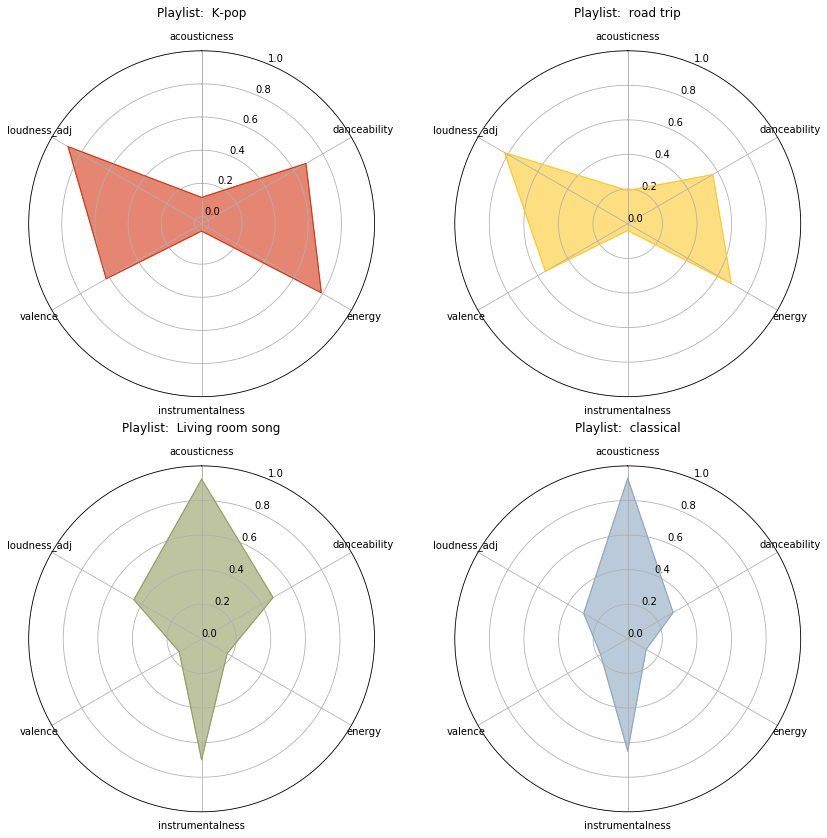

In [33]:
draw_radar(feature_mean.index.values[0],feature_mean.index.values[7],feature_mean.index.values[1],feature_mean.index.values[6],
           '#d23514','#fdc82c','#959d61','#8ca8be')

C:\Users\86136\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 55357 missing from current font.

C:\Users\86136\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 56491 missing from current font.

C:\Users\86136\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning:

Glyph 55357 missing from current font.

C:\Users\86136\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning:

Glyph 56491 missing from current font.



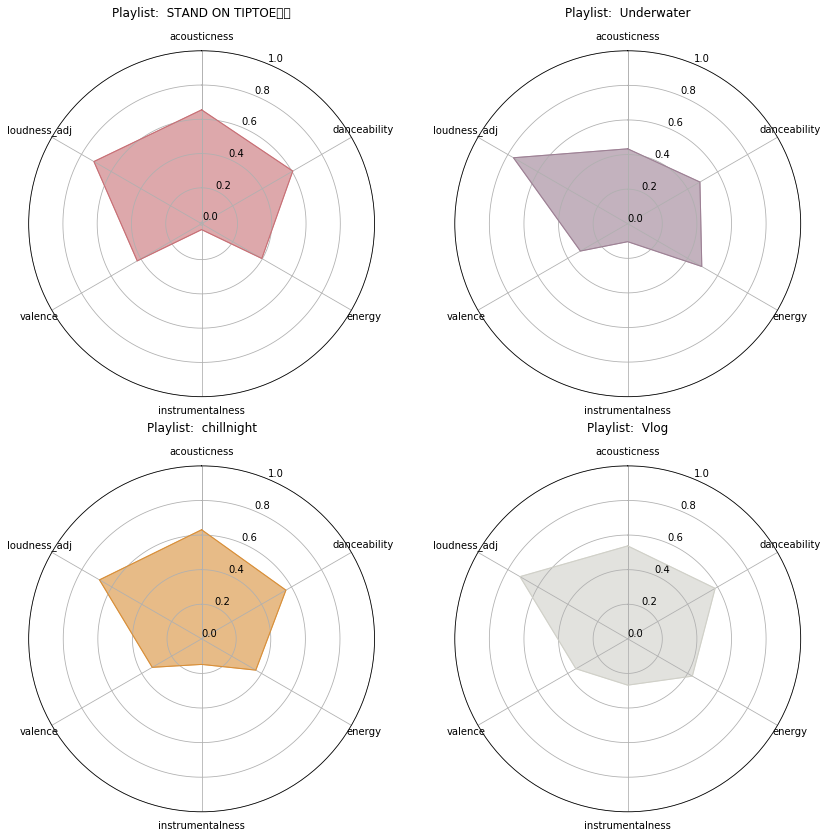

In [34]:
draw_radar(feature_mean.index.values[2],feature_mean.index.values[3],feature_mean.index.values[5],feature_mean.index.values[4],
            '#c76e74','#9c7f93','#d88e37','#d0d0c8')

I inspected the following features in the radar chart: acousticsness, danceability, energy, instrumentalness, loudness, valance. Except for loudness, all other features are on 0–1 scale, thus I first converted loudness to the scale of 0–1. I drew each playlist a radar chart to display and compare the listed features. And the charts showed the playlist Living room song and classical are most acoustic and instrumental since most of the songs in these two playlists are purely instrumental work. While K-pop and road trips are significantly loud and full of energy. The rest of four playlists are quite balanced.

## 3. Overall popularity of my playlist

In [20]:
list_song_feature["list_name"].unique()

array(['Living room song', 'Underwater', 'STAND ON TIPTOE💫', 'Vlog',
       'classical', 'chillnight', 'road trip', 'K-pop'], dtype=object)

In [22]:
fig = go.Figure()

playlists = list_song_feature["list_name"].unique()

for playlist in playlists:
    fig.add_trace(go.Box(x=list_song_feature['list_name'][list_song_feature['list_name'] == playlist],
                            y=list_song_feature['popularity'][list_song_feature['list_name'] == playlist],
                            name=playlist,
                            marker_color='rgb(129,180,227)'
                            ))
fig.update_traces(
                  boxpoints='all', # show all points
                  ) 
fig.update_layout(showlegend=False,xaxis_tickangle=-30,
                 title="Distribution of track popularity",
                  xaxis_title="Playlist")
fig.show()

Next, let's explore how popular are my playlist songs. Through the boxplot chart of popularity index, I can tell that most of my playlist songs are of 50–60 popularity. The list K-pop is the most popular one, and classical is the most unpopular one. It's quite reasonable since people nowadays pay less attention to classical music pieces unless the piece is exceptionally famous. The list chillnight and STAND ON TIPTOE 💫 have sparse distribution in terms of popularity score. The highest popularity is slightly higher than 80, indicating that I seem not to be a fan of "hit songs".

## 4. How old are the songs in my playlists?

In [23]:
# First, take the year value of the realese_date for each song
list_song_feature['year'] = pd.DatetimeIndex(list_song_feature['release_date']).year
list_song_feature.head()

,id,spotify_id,list_name,list_id,song_id,song_name,artist,popularity,release_date,energy,...,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key,year
0,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,1zd9Nv6NrTLUVbwmmFngPi,Ágúst,Ólafur Arnalds,41,2011-12-05,0.1370,...,0.0324,0.983,0.935,0.394,186067,-17.482,0.0769,1,9,2011
1,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,2Tax7fSPDly9OLIAZRd0Dp,Through The Dark,Alexi Murdoch,47,2011-03-08,0.1270,...,0.0439,0.958,0.916,0.566,330067,-18.624,0.1890,1,7,2011
2,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,2MfOJ47XPZcUS03hZ1UXTT,Slow Revolution,Alexi Murdoch,30,2011-03-08,0.2250,...,0.0326,0.987,0.587,0.607,355800,-15.875,0.2050,1,0,2011
3,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,6gQYrjesTMHBqUVx4UPgBM,Towards The Sun,Alexi Murdoch,36,2011-03-08,0.1890,...,0.0313,0.926,0.799,0.403,282920,-17.591,0.1810,1,1,2011
4,1,2A2PYXAiS8qUmhOTmWlhLh,Living room song,2A2PYXAiS8qUmhOTmWlhLh,2NePZXMHgRs7kuIkLBxKYK,"3 Piano Pieces, Op. 34: Yo meren rannalla (Night By the Sea), Op. 34, No. 1",Heino Kaski,21,1997-12-31,0.0226,...,0.0454,0.991,0.932,0.254,186627,-27.916,0.0684,0,1,1997


In [24]:
# calculate how many songs are in my playlist for each release year
release_year = list_song_feature.groupby("year", as_index=False)["song_id"].count()
release_year

,year,song_id
0,1980,1
1,1981,1
2,1983,1
3,1987,1
4,1989,2
5,1992,1
6,1993,1
7,1997,2
8,2001,2
9,2002,1


In [25]:
# Since there are some year without any song, create a full range of release year 
idx = pd.DataFrame(range(1980,2021),columns=['Release Year'])

# then merge the idx with df"release_year" that is just created
release_year_new = pd.merge(idx,release_year,how='left',left_on='Release Year',right_on = 'year',copy=False)

In [26]:
release_year_new.drop("year",inplace=True,axis=1)
release_year_new

,Release Year,song_id
0,1980,1.0
1,1981,1.0
2,1982,NaN
3,1983,1.0
4,1984,NaN
5,1985,NaN
6,1986,NaN
7,1987,1.0
8,1988,NaN
9,1989,2.0


In [27]:
# visualize it
fig = go.Figure(data=
    go.Bar(name='Number of Song', x=release_year_new["Release Year"], y=release_year_new.song_id,marker_color='rgb(129,180,227)'),)
# Change the bar mode
fig.update_layout(xaxis_tickangle=-45,
                  title="Number of track distribution by release year",
                  xaxis_title="Year")
fig.show()

Most of the bookmarked songs are released around 2017,2018. Seems I'm not a RETRO guy in music!

## 5. Key and Mode

In [28]:
# calculate how many songs are in my playlist for each release year
key_mode = list_song_feature.groupby(["key","mode"], as_index=False)["song_id"].count()
key_mode

,key,mode,song_id
0,0,0,1
1,0,1,17
2,1,0,8
3,1,1,7
4,2,0,1
5,2,1,16
6,3,0,4
7,3,1,9
8,4,0,9
9,4,1,10


In [29]:
# map the key in number to the real key represented in alphabet
key_dic = {0: "C", 
           1: "C♯/D♭",
           2: "D",
           3: "D♯/E♭",
           4: "E",
           5: "F",
           6: "F♯/G♭",
           7: "G",
           8: "G♯/A♭",
           9: "A",
           10: "A♯/B♭",
           11: "B"}
key_mode = key_mode.replace({"key": key_dic})

In [30]:
fig = go.Figure(go.Bar(x=key_mode["key"][key_mode["mode"]==0],
                       y=key_mode["song_id"][key_mode["mode"]==0], 
                       name='Mode=0',marker_color='rgb(129,180,227)'))
fig.add_trace(go.Bar(x=key_mode["key"][key_mode["mode"]==1], 
                     y=key_mode["song_id"][key_mode["mode"]==1], 
                     name='Mode=1',marker_color='rgb(76,153,160)'))

fig.update_layout(barmode='stack',
                 title = "Distribution of track key and track mode",
                 xaxis_title = "Key")
fig.show()

Key and mode are two essential features of tracks. Music with different keys has different styles, but minor differences can only be identified by professional musicians. However, it's easier to recognize major versus minor mode: major scales are usually more bright or cheerful, while minor keys sound more melancholy and sad. Check out this Youtube video to have a more straightforward connection with sample audio. According to the below figure, I can tell that I prefer major mode than minor mode. I like songs that make me happy and light my life!

## 6. Valence index 

In [23]:
list_song_feature.sort_values("valence")

,Unnamed: 0,id,spotify_id,list_name,list_id,song_id,song_name,artist,popularity,release_date,...,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key
81,88,5,0V9tGGZlC90BbrCY1FNmXD,classical,0V9tGGZlC90BbrCY1FNmXD,4Fwh7LLCxx9Z3nKQSszq4d,"Vivaldi: Violin Concerto in F Major, RV 293 ""L'autunno"" (No. 3 from ""Il cimento dell'armonia e dell'inventione"", Op. 8): II. Adagio molto",Antonio Vivaldi,41,1989,...,112.487,0.0364,0.5530,0.357000,0.190,175400,-33.712,0.0375,0,11
77,84,5,0V9tGGZlC90BbrCY1FNmXD,classical,0V9tGGZlC90BbrCY1FNmXD,1eaETfQqYI5YBDq5zj7O5Y,Wild Swans Suite: 2. Eliza Aria (Arr. for Piano),Elena Kats-Chernin,30,2019-03-29,...,80.867,0.0409,0.9700,0.876000,0.303,190627,-21.728,0.0389,1,5
70,77,5,0V9tGGZlC90BbrCY1FNmXD,classical,0V9tGGZlC90BbrCY1FNmXD,1M2RkUUJ9wXRsW3jN1MCHS,"4 Impromptus, Op.90, D.899: No.4 in A Flat Major: Allegretto",Franz Schubert,0,1983-01-01,...,125.242,0.0398,0.9870,0.922000,0.343,497773,-27.015,0.0393,1,8
94,102,6,7AKmNNcW1VqcKHwrGJBVly,chillnight,7AKmNNcW1VqcKHwrGJBVly,06saP1KfOa0j93jO8XnCUT,Silk Threads,Enrico Pieranunzi,56,2020-02-07,...,84.417,0.0535,0.9670,0.891000,0.462,274673,-20.827,0.0550,1,9
71,78,5,0V9tGGZlC90BbrCY1FNmXD,classical,0V9tGGZlC90BbrCY1FNmXD,0pbkUtDGFryyvaiNhaRXaN,"Beethoven: Piano Trio No. 7 in B-Flat Major, Op. 97, ""Archduke"": III. Andante cantabile ma però con moto",Ludwig van Beethoven,19,2020-02-28,...,74.498,0.0411,0.9820,0.887000,0.207,777253,-27.716,0.0572,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,157,8,5xs3KPXahrJlsQaeAh3crc,K-pop,5xs3KPXahrJlsQaeAh3crc,7x5shgmSrMeIfeGIVzspPK,Milkshake,Red Velvet,45,2019-06-19,...,167.813,0.2430,0.0431,0.000004,0.526,210696,-5.855,0.8400,1,11
105,115,6,7AKmNNcW1VqcKHwrGJBVly,chillnight,7AKmNNcW1VqcKHwrGJBVly,7zfXCz91JElheFTK7tjPco,Hey Sun,HYUKOH,45,2020-01-30,...,114.982,0.0360,0.3720,0.037900,0.790,205598,-12.790,0.8470,0,1
164,185,8,5xs3KPXahrJlsQaeAh3crc,K-pop,5xs3KPXahrJlsQaeAh3crc,4Is1b37KJY9XVCgzp81FBW,BAAM,MOMOLAND,64,2018-06-26,...,127.051,0.0435,0.1150,0.004310,0.725,208475,-2.320,0.9050,0,5
126,138,7,63pNL4PuMMiLg5BSW0yTLk,road trip,63pNL4PuMMiLg5BSW0yTLk,29imR7dda5XqwPRFmby7HS,"Baby, I Love You",Ramones,61,1980-02-04,...,107.779,0.0269,0.2020,0.000307,0.735,224560,-5.533,0.9300,1,8


The most SAD song in my playlists are is Violin Concerto in F Major, RV 293 "L'autunno" from *Vivaldi*, and the most HAPPY song is Russian Roulette from *Red Velvet*.

# Further, analyze the history of my listened music since I start to use Spotify

- I start using Spotify after the Master Program started in United States. Before that, I mostly use Apple Music and Netease Music.
- The main question I'd like to answer are:   
    1) How often do I listen to music?
    2) Who are the most listened artists and what are my top10 most listened song?  
    3) How was my mood in the past days according to the song mood?  

## 1.How often did I listen to music?

In [42]:
my_streaming['mins_played'] = my_streaming.apply(lambda x: round(x['ms_played']/60000,2), axis=1)
my_streaming['date'] = my_streaming.apply(lambda x: pd.to_datetime(x['end_time'][:10],format='%Y-%m-%d'),axis=1)

# calculate the daily streaming time length 
daily_length = my_streaming.groupby('date',as_index=True).sum()

In [43]:
# create new date series for displaying time series data
idx = pd.DataFrame(pd.date_range(min(my_streaming.date), max(my_streaming.date)),columns=['date'])
idx['date'] = idx.apply(lambda x: pd.to_datetime(x['date'],format='%Y-%m-%d'),axis=1)

#use new date seriesto display the daily streaming time
new_daily_length = pd.merge(idx,daily_length,how='left',left_on='date',right_on = 'date',copy=False)
new_daily_length

,date,ms_played,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key,mins_played
0,2019-07-13,7948930.0,22.32170,6.7466,5851.908,2.1912,26.627655,18.771523,25.699,10518407.0,-429.938,14.9353,40.0,281.0,132.52
1,2019-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2020-06-08,7665491.0,14.95009,5.5239,3860.879,1.4262,20.244840,4.899433,18.504,8202203.0,-408.144,11.4541,28.0,187.0,127.75
332,2020-06-09,21396908.0,47.77990,16.3160,11446.836,4.6954,49.731830,2.977764,52.555,23480778.0,-758.238,34.7264,79.0,536.0,356.62
333,2020-06-10,11715787.0,4.67457,4.0955,4066.970,2.0402,38.701000,33.262975,15.727,11067640.0,-998.971,8.4115,23.0,199.0,195.31
334,2020-06-11,13668249.0,35.34270,12.2436,7847.131,3.7460,33.613865,13.864628,40.473,15639021.0,-681.789,31.2084,51.0,336.0,227.79


C:\Users\86136\Anaconda3\lib\site-packages\calmap\__init__.py:221: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



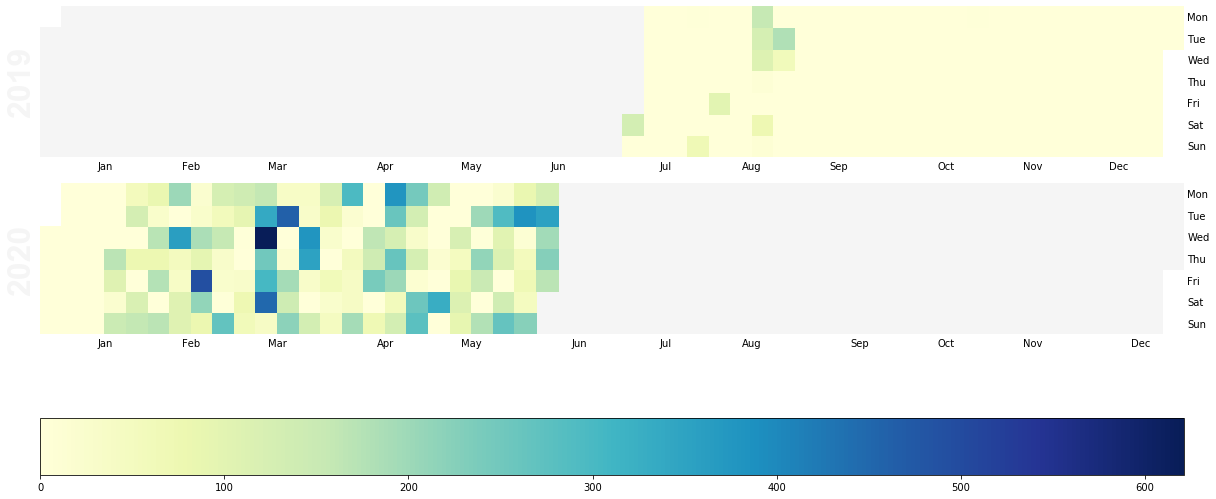

In [44]:
from matplotlib.pyplot import figure
%matplotlib inline
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')


fig,ax=calmap.calendarplot(new_daily_length.groupby('date',as_index=True).sum()['mins_played'],
                           cmap='YlGnBu',
                          linewidth=0,
                          fig_kws=dict(figsize=(17,8)))
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist(),orientation='horizontal')


#Colormap BuGn_d is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r


I often tell people that I can't live without music, I keep listening everyday… But do I? The heatmap calendar plot below tells me the truth: No, I don't! (The darker the blue square, the longer the time I play the music on that day. The large blank space in 2019 is because I was an Apple music user before I switched to Spotify.) According to the heatmap, I took around one day off from music each week.

## 2.who do I listened to most?

In [45]:
# calculate total mins I listened per 
artist_length = my_streaming.groupby('artist_name',as_index=False).sum()
artist_song_cnt = my_streaming.groupby('artist_name',as_index=False).agg({"track_name": "nunique"})

# merge artist_length and artist_song_cnt 
artist_length_uniqsong = pd.merge(artist_length,artist_song_cnt,how='left',on='artist_name',copy=False)
artist_length_uniqsong.rename(columns={'track_name':'unique_track_number'}
          ,inplace=True)
artist_length_uniqsong

,artist_name,ms_played,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key,mins_played,unique_track_number
0,(G)I-DLE,1609264,6.347,1.1706,889.193,0.4093,0.3911,0.000025,5.626,1620054.0,-29.075,3.200,1.0,32.0,26.82,5
1,015B,771004,1.209,0.3467,355.044,0.1727,2.2340,0.000001,2.117,771047.0,-24.685,1.716,3.0,17.0,12.84,3
2,10cm,170755,0.490,0.0960,93.639,0.1400,0.7130,0.000000,0.770,170755.0,-5.659,0.549,1.0,0.0,2.85,1
3,1set,189015,0.615,0.1180,109.997,0.0277,0.5680,0.000000,0.815,189016.0,-4.768,0.794,1.0,2.0,3.15,1
4,20 Years of Age,235183,0.381,0.1080,103.892,0.0270,0.6760,0.000000,0.693,235160.0,-4.769,0.586,1.0,9.0,3.92,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,박혜경 (Hye Kyung Park),45182,0.302,0.1100,120.014,0.0417,0.6450,0.000000,0.843,219925.0,-7.107,0.469,0.0,9.0,0.75,1
1096,발라드가수들,241397,0.545,0.3120,127.981,0.0355,0.8010,0.000000,0.498,241398.0,-6.539,0.235,1.0,5.0,4.02,1
1097,지효,370876,1.156,0.2480,259.830,0.0656,0.9080,0.000000,1.450,371066.0,-10.072,1.068,0.0,14.0,6.18,1
1098,피아니카 Pianica,514874,0.858,0.1941,359.586,0.1410,2.5860,0.073500,2.496,767121.0,-20.541,1.134,3.0,0.0,8.58,1


In [46]:
fig = px.scatter(artist_length_uniqsong, x="mins_played", y="unique_track_number",
                 log_x=True,# since the data converged in lower value of mins_played, I here use log_x to make the display more sparsed
                 hover_name="artist_name", hover_data=["mins_played", "unique_track_number"]
                )


fig.update_layout(
    xaxis_title="Total minutes played",
    yaxis_title="Total unique tracks played",
    height=600,
    title_text='Who Did I Listened To Most?'
#      ,paper_bgcolor='rgb(252, 253, 255)'
#     ,plot_bgcolor='rgb(252, 253, 255)'
    ,yaxis=dict(
        showgrid=True,
        showline=True,
        showticklabels=True,
        linecolor='rgba(102, 102, 102, 0.8)'
    )
     , xaxis=dict(
        zeroline=True,
        showline=True,
        showticklabels=True,
        showgrid=True,
        linecolor='rgba(102, 102, 102, 0.8)'
    )
    
)
fig.add_annotation(
            x=log(865.6799999999999,10),
            y=101,
            text="Johann Sebastian Bach")
fig.add_annotation(
            x=log(600.92999999,10),
            y=71,
            text="Fats Waller")
fig.add_annotation(
            x=log(1079.33,10),
            y=63,
            text="Franz Joseph Haydn")
fig.add_annotation(
            x=log(989.219999999,10),
            y=58,
            text="Rachael Yamagata")
fig.add_annotation(
            x=log(380.69,10),
            y=52,
            text="Claude Debussy")
fig.add_annotation(
            x=log(142.75,10),
            y=36,
            text="Girls' Generation")
fig.add_annotation(
            x=log(849.95,10),
            y=24,
            text="Peter Marsh")
fig.update_annotations(dict(
            xref="x",
            yref="y",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
))
fig.show()

- add wordcloud

In [47]:
from wordcloud import WordCloud

artist_freq = my_streaming.groupby('artist_name',as_index=False).sum()[['artist_name','mins_played']]
artist_freq

artist_freq = dict(zip(artist_freq['artist_name'].tolist(), artist_freq['mins_played'].tolist()))

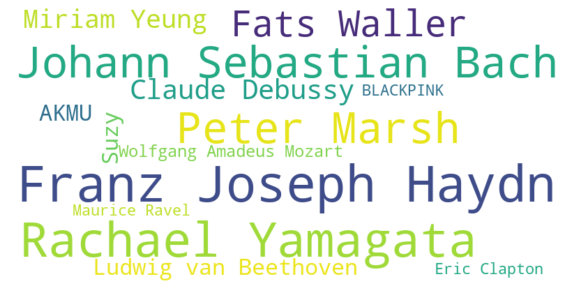

In [48]:
wc = WordCloud(background_color='white',width=800, height=400, max_words=14).generate_from_frequencies(artist_freq)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

According to the streaming history, I listened to classical music a lot, mostly from Bach, Franz, and Debussy. I have played more than 100 different pieces of Bach last year. It indicates that I randomly played his work at most of the time instead of putting some works in cycle. In contrast, for Peter Marsh, I played almost the same amount of time but only covered around 20 songs of him. The song that I repeated most is exactly from Peter March. I have played his Christmas Tree for over 400 minutes, much more than I played other songs.
  
According to the top songs and top artists that I have listened to in the past year, almost half are classical music. I didn't realize that I was so into classical pieces until I look at the data.

## 3. My top10 most listened song?

In [49]:
top_10_song = my_streaming.groupby(['track_id','track_name',"artist_name"]).sum()
top_10_song.reset_index(inplace=True)
top_10_song = top_10_song[['track_id','track_name','mins_played',"artist_name"]]
top_10_song

,track_id,track_name,mins_played,artist_name
0,00CuHVcHWJLGGqcflTF806,Money Fame Thunder,11.46,Rachael Yamagata
1,00S4PrcWUb3f3dQ9PuC0uy,2U,3.25,KANG DANIEL
2,00m7Q2wHED7wAbYq83XxOh,Sunlight,3.12,The Youngbloods
3,010ALbbh5KlQ4fKWgSdhRd,Look On Down From The Bridge,4.80,Mazzy Star
4,011lckwlhTjsisywSudFnV,I Want You (Acoustic),9.21,Rachael Yamagata
...,...,...,...,...
2837,7zTTDkkLkJ2iHAqq1daDCr,OUTTA MY MIND,3.78,Monsune
2838,7zdf71bLwMcCOk7K4DvL7G,"Let's walk, I am waiting in front of your house (feat.Ju Yein)",3.92,20 Years of Age
2839,7zfXCz91JElheFTK7tjPco,Hey Sun,8.77,HYUKOH
2840,7ztlf9mCrjoLXAYYf0LCYx,No Different,3.33,Epik High


In [50]:
pd.set_option('display.max_colwidth', -1)

In [51]:
top_10_song = top_10_song.nlargest(10,'mins_played')
top_10_song[["track_name","mins_played","artist_name"]]

,track_name,mins_played,artist_name
68,Christmas Tree,422.48,Peter Marsh
965,"No Direction [From 'One Spring Night' (Original Television Soundtrack), Pt. 1]",71.97,Rachael Yamagata
127,"Symphony No. 9 in D Minor, Op. 125 ""Choral"": IV. Presto - Allegro assai",62.87,Ludwig van Beethoven
2094,"Toccata in E Minor, BWV 914",61.02,Johann Sebastian Bach
1048,Only The Young - Featured in Miss Americana,54.36,Taylor Swift
2186,Don't Forget,54.36,Peter Marsh
1122,"Symphony No. 5 in C Minor, Op. 67: I. Allegro con brio",48.09,Ludwig van Beethoven
927,"Symphony No. 7 in C Major, Hob. I:7 ""Le Midi"": II. Recitativo, Adagio",47.70,Franz Joseph Haydn
544,"Keyboard Partita No. 6 in E Minor, BWV 830: I. Toccata",47.04,Johann Sebastian Bach
1156,Touch,45.04,Cigarettes After Sex


In [52]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(
            x=['Christmas Tree',
                'Only The Young-<br>Featured in Miss Americana',
                "Don't Forget",
                "Will Last Forever",
                "Piano Sonata No. 52 in<br>E-Flat Major, Hob. XVI:...",
                "Keyboard Partita No. 6<br>in E Minor, BWV 830: V....",
                "Toccata in E Minor, BWV 914",
                'Touch',
                'Symphony No. 7 in C Major,<br>Hob. I:7 Le Midi:..',
              ' Keyboard Partita No. 6 in E Minor, BWV 830: I'],
            y=top_10_song["mins_played"],
            orientation='v',
            showlegend=True,
            name="Accumulated streaming time(mins)",
            marker_color='rgb(129,180,227)' 
))
fig.update_layout(
    height=588,width=1000,
    title_text='Which song do I listened to most?',
    legend_orientation="h",
    legend=dict(
        x=0.6,
        y=0.95,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        )    
        # bgcolor=rgb
    )
#     ,paper_bgcolor='rgb(252, 253, 255)'
#     ,plot_bgcolor='rgb(252, 253, 255)'
)

fig.show()

## 4. How's my mood in the past year?

In [92]:
# calculate the mood index mean and s.d. for each day

# def the function to calculate population standard deviation instead the defult sample s.d.
def pop_std(x):
    return x.std(ddof=0)

mood = my_streaming.groupby("date", as_index=False).agg({'valence':['mean',pop_std]})
mood.head(10)

date   valence          
                  mean   pop_std
0 2019-07-13  0.304802  0.224337
1 2019-07-29  0.135900  0.098100
2 2019-08-04  0.550852  0.229523
3 2019-08-09  0.423202  0.253615
4 2019-08-19  0.274902  0.218502
5 2019-08-20  0.448514  0.239553
6 2019-08-21  0.464269  0.209945
7 2019-08-22  0.325800  0.131787
8 2019-08-24  0.449263  0.193385
9 2019-08-25  0.301333  0.114500

In [94]:
mood.columns = ['_'.join(col) for col in mood.columns]

In [95]:
mood

,date_,valence_mean,valence_pop_std
0,2019-07-13,0.304802,0.224337
1,2019-07-29,0.135900,0.098100
2,2019-08-04,0.550852,0.229523
3,2019-08-09,0.423202,0.253615
4,2019-08-19,0.274902,0.218502
...,...,...,...
132,2020-06-08,0.336885,0.196333
133,2020-06-09,0.354351,0.183605
134,2020-06-10,0.205159,0.216709
135,2020-06-11,0.445834,0.256600


In [96]:
mood.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 136
Data columns (total 3 columns):
date_              137 non-null datetime64[ns]
valence_mean       137 non-null float64
valence_pop_std    137 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.3 KB


In [98]:
# create new date series for displaying time series data
idx = pd.DataFrame(pd.date_range(min(my_streaming.date), max(my_streaming.date)),columns=['date'])
idx['date'] = idx.apply(lambda x: pd.to_datetime(x['date'],format='%Y-%m-%d'),axis=1)

In [107]:
#use new date series to display the daily streaming time
new_daily_valence = pd.merge(idx,mood,how='left',left_on="date",right_on="date_",copy=False).fillna(0)
new_daily_valence = new_daily_valence[new_daily_valence["date"]>"2020-01-01"]

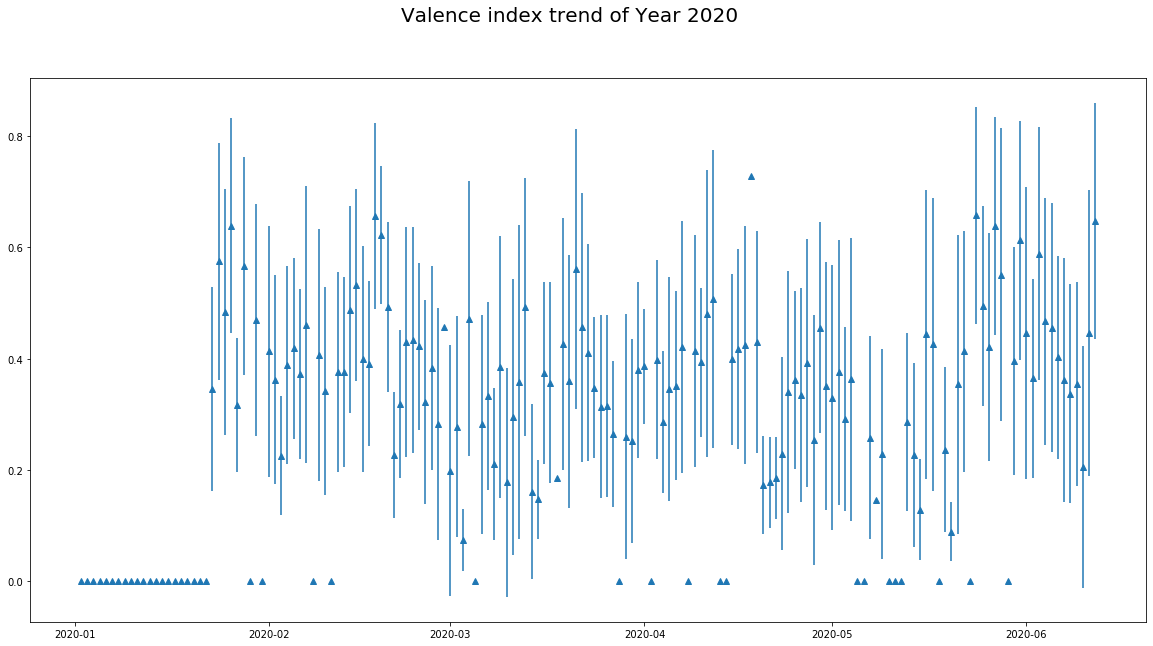

In [113]:
fig= plt.figure(figsize=(20,10))
fig.suptitle('Valence index trend of Year 2020', fontsize=20) # Add the text/suptitle to figure

plt.errorbar(new_daily_valence["date"],new_daily_valence["valence_mean"], new_daily_valence["valence_pop_std"], 
             linestyle='None',marker='^')
plt.show()

The valence index calculated by Spotify indicates how happy or sad a song is, which helps me track my mood along time. I used error bar plot to indicate both mean valence and variance of the valence of each day. The graph below shows that I seem not to be in a good feeling in the first half of March and in May. Hmmm, it happened to be the final exam stage of two quarters in my Master's Program when I was really busy and stressed. Then that makes a lot of sense!